# Tutorial: Ground State of 1D Transverse-field Ferromagnetic Ising Model (TFIM) with RNN wavefunctions

Code by **Mohamed Hibat Allah** and **Martin Ganahl**.



**This notebook is intended to help the reader to get familiarized with Exact Diagonalization (ED) and Positive Recurrent Neural Networks (pRNN) wavefunctions. Here, we just explore small system sizes for pedagogical purposes and to keep the running time very short.**


Check if you specifying the right "path" below to the google colab notebook on Drive to make sure everything below is working properly

Make sure also you use a GPU by going to "Runtime/Change Runtime type" in Google Colaboratory to get a speedup

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
path = 'gdrive/My Drive/RNNWavefunctions/RNNWavefunctions-master/1DTFIM'
sys.path.append(path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import itertools
np.array(list(itertools.product([0, 1], repeat=3)))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

## **Calculating the ground state energy of 1DTFIM using Exact Diagonalization (ED)**

Here, we attempt to calculate the ground state and the ground state energy of the 1D Transverse field Ising Model with Open Boundary Conditions using Exact diagonalization.

The Hamiltonian is given as follows:

$$\hat{H}_{\text{TFIM}} = - \sum_{\langle i,j \rangle} \hat{\sigma}^{z}_i \hat{\sigma}^{z}_j - B_x \sum_{i} \hat{\sigma}^{x}_i $$

where ${\bf \sigma}_i$ are pauli matrices.  Here,
$\langle i,j \rangle$ denote
nearest neighbor pairs.

In [1]:
def IsingMatrixElements(Jz,Bx,sigmap):
    """
    computes the matrix element of the open Ising Hamiltonian for a given state sigmap
    -----------------------------------------------------------------------------------
    Parameters:
    Jz: np.ndarray of shape (N), respectively, and dtype=float:
                Ising parameters
    sigmap:     np.ndarrray of dtype=int and shape (N)
                spin-state, integer encoded (using 0 for down spin and 1 for up spin)
                A sample of spins can be fed here.
    Bx: Transvers magnetic field (N)
    -----------------------------------------------------------------------------------            
    Returns: 2-tuple of type (np.ndarray,np.ndarray)
             sigmas:         np.ndarray of dtype=int and shape (?,N)
                             the states for which there exist non-zero matrix elements for given sigmap
             matrixelements: np.ndarray of dtype=float and shape (?)
                             the non-zero matrix elements
    """
    #the diagonal part is simply the sum of all Sz-Sz interactions
    diag=0
    
    sigmas=[]
    matrix_elements=[]
    N = Jz.shape[0]
    
    for site in range(N-1):
        if sigmap[site]==sigmap[site+1]: #if the two neighouring spins are the same (We use open Boundary Conditions)
            diag-=Jz[site] #add a negative energy contribution (We use ferromagnetic couplings)
        else:
            diag+=Jz[site]
            
    matrix_elements.append(diag)
    sigmas.append(sigmap)
    
    #off-diagonal part (For the transverse Ising Model)
    for site in range(N):
        if Bx[site] != 0:
            sig = np.copy(sigmap)
            sig[site]=np.abs(1-sig[site])
            matrix_elements.append(-Bx[site])
            sigmas.append(sig)    

    return np.array(sigmas),np.array(matrix_elements)

def ED_1DTFIM(N=10, h = 1):
  """
  Returns a tuple (eta,U)
    eta = a list of energy eigenvalues.
    U = a list of energy eigenvectors
  """
  Jz=+np.ones(N)
  Bx=+h*np.ones(N)

  basis = []
  #Generate a z-basis
  for i in range(2**N):
      basis_temp = np.zeros((N))
      a = np.array([int(d) for d in bin(i)[2:]])
      l = len(a)
      basis_temp[N-l:] = a
      
      basis.append(basis_temp)
  basis = np.array(basis)
      
  H=np.zeros((basis.shape[0],basis.shape[0])) #prepare the hamiltonian
  for n in range(basis.shape[0]):
      sigmas,elements=IsingMatrixElements(Jz,Bx,basis[n])
      for m in range(sigmas.shape[0]):
          for b in range(basis.shape[0]):
              if np.all(basis[b,:]==sigmas[m,:]):
                  H[n,b]=elements[m]
                  break
  eta,U=np.linalg.eigh(H) #diagonalize
  return eta,U


It may take some time to do exact diagonalization. You can try up to $N=12$ spins otherwise you have to wait for a very long time.

In [20]:
h = [0.8, 1.2]
for i in range (len(h)):
    eta, U = ED_1DTFIM(N=12, h=h[i])

    print('The ground state energy is:')
    print(min(eta))
    E_exact = min(eta)
    np.save("ground_state_Bx_"+str(h[i])+".npy", U[:,np.nonzero(eta==np.min(eta))[0][0]])
    np.save("ground_energy_Bx_"+str(h[i])+".npy",min(eta))

The ground state energy is:
-13.391526827970043
The ground state energy is:
-16.786540228588716


float64


## **Representing the ground state**

Sometimes it is useful to represent the ground state in a plot as shown below, to know some information about the properties of the ground state, such as symmetries, sign of the amplitudes,...

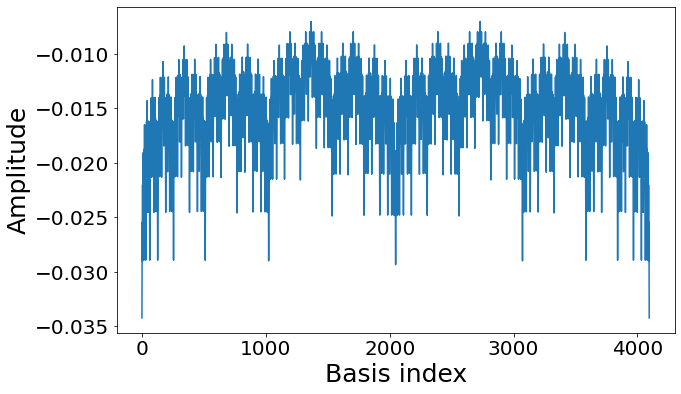

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

ground_state = U[:,np.nonzero(eta==np.min(eta))[0][0]]

plt.plot(ground_state,label="Ground state")

ax.set_xlabel(r'Basis index', fontsize = 25)
ax.set_ylabel('Amplitude', fontsize = 25)

plt.show()

In [1]:
import tensorflow as tf

# Create a tensor
tensor = tf.constant([1, 2, 3])

# Start a session
with tf.Session() as sess:
    # Run the session to evaluate the tensor
    tensor_value = sess.run(tensor)
    print(tensor_value)


[1 2 3]


We notice here that the amplitudes of the ground state in the z-basis do not change sign, hence we can use a positive recurrent neural network wavefunction (pRNN wavefunction).

## **Calculating the ground state energy using an RNN wavefunction**

After that we obtained the ground state energy from exact diagonalization, we are going to value as a reference to assess the quality of the variational energy calculated by the pRNN wavefunction

In [2]:
from TrainingRNN_1DTFIM import run_1DTFIM

#numsteps = number of training iterations
#systemsize = number of physical spins
#Bx = transverse magnetic field
#numsamples = number of samples used for training
numsamples = 512
#num_units = number of memory units of the hidden state of the RNN
#num_layers = number of vertically stacked RNN cells
Bx = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 3.0, 3.5]
#This function trains a pRNN wavefunction for 1DTFIM with the corresponding hyperparams
for i in range(len(Bx)):
    RNNEnergy, varRNNEnergy = run_1DTFIM(numsteps = 3000, systemsize = 12, Bx = Bx[i], num_units = 32,  num_layers = 1, numsamples = numsamples, learningrate = 5e-3, seed = 111)

#RNNEnergy is a numpy array of the variational energy of the pRNN wavefunction
#varRNNEnergy is a numpy array of the variance of the variational energy of the pRNN wavefunction


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

The number of variational parameters of the pRNN wavefunction is 3458


mean(E): -5.67480655222065, var(E): 10.443854162377448, #samples 512, #Step 0 


mean(E): -10.270054021989509, var(E): 3.7963064591976554, #samples 512, #Step 10 


mean(E): -11.014320026641855, var(E): 2.4918850245158684, #samples 512, #Step 20 


mean(E): -11.11291975648934, var(E): 1.3261811871672748, #samples 512, #Step 30 


mean(E): -11.309877883451371, var(E): 2.513476264350283, #samples 512, #Step 40 


mean(E): -11.389326829646938, var(E): 1.5710077420002229, #samples 512, #Step 50 


mean(E): -11.574733042149902, var(E): 1.0765737447557866, #samples 512, #Step 60 


mean(E): -11.705845059339001, var(E): 0.5443838977194817, #samples 512, #Step 70 


mean(E): -11.710812563149

mean(E): -11.892085614189252, var(E): 0.000778242991490571, #samples 512, #Step 910 


mean(E): -11.890349788721796, var(E): 0.00029616696231306224, #samples 512, #Step 920 


mean(E): -11.892330439489431, var(E): 0.00040958665571622793, #samples 512, #Step 930 


mean(E): -11.891240609887925, var(E): 0.0010921415048959812, #samples 512, #Step 940 


mean(E): -11.891977492552591, var(E): 0.0004770929489615739, #samples 512, #Step 950 


mean(E): -11.894169683550107, var(E): 0.001093951068234739, #samples 512, #Step 960 


mean(E): -11.890424052769422, var(E): 0.0005268014143920316, #samples 512, #Step 970 


mean(E): -11.89149443744631, var(E): 0.0011701247151651043, #samples 512, #Step 980 


mean(E): -11.889924405059887, var(E): 0.0011335636736754411, #samples 512, #Step 990 


mean(E): -11.89146280824136, var(E): 0.0004314813852354161, #samples 512, #Step 1000 


mean(E): -11.893855804393045, var(E): 0.000841567481570553, #samples 512, #Step 1010 


mean(E): -11.891916006697617, var

mean(E): -11.892054762998391, var(E): 9.005360850836413e-05, #samples 512, #Step 1840 


mean(E): -11.891166260272062, var(E): 0.0006975666221902753, #samples 512, #Step 1850 


mean(E): -11.891953486098853, var(E): 0.0003198399025191422, #samples 512, #Step 1860 


mean(E): -11.892005146604323, var(E): 0.00038610640450123323, #samples 512, #Step 1870 


mean(E): -11.891206072509794, var(E): 0.0005701299512527827, #samples 512, #Step 1880 


mean(E): -11.891706526834419, var(E): 0.0002096334246036517, #samples 512, #Step 1890 


mean(E): -11.891798462005761, var(E): 0.0018648865346086933, #samples 512, #Step 1900 


mean(E): -11.89151800572478, var(E): 0.0009031436933153948, #samples 512, #Step 1910 


mean(E): -11.891205406803465, var(E): 0.0006297123547352559, #samples 512, #Step 1920 


mean(E): -11.892474823389119, var(E): 0.0004069377586297905, #samples 512, #Step 1930 


mean(E): -11.893122147195456, var(E): 0.0004815026605026299, #samples 512, #Step 1940 


mean(E): -11.89246857

mean(E): -11.892680336861917, var(E): 0.0001460706740423517, #samples 512, #Step 2760 


mean(E): -11.890138473308935, var(E): 0.0003937470494869388, #samples 512, #Step 2770 


mean(E): -11.891322894749592, var(E): 0.00011258170042743133, #samples 512, #Step 2780 


mean(E): -11.892638293377129, var(E): 0.00010169568478977342, #samples 512, #Step 2790 


mean(E): -11.89259160457134, var(E): 9.220727554858356e-05, #samples 512, #Step 2800 


mean(E): -11.891310805608693, var(E): 0.00013904944884265743, #samples 512, #Step 2810 


mean(E): -11.891917791000344, var(E): 0.00029155019742062646, #samples 512, #Step 2820 


mean(E): -11.892026365283652, var(E): 8.54516698808237e-05, #samples 512, #Step 2830 


mean(E): -11.891372327598358, var(E): 2.7570348987437177e-05, #samples 512, #Step 2840 


mean(E): -11.890834861912513, var(E): 0.00012385156887342945, #samples 512, #Step 2850 


mean(E): -11.891939387893254, var(E): 7.573728938533497e-05, #samples 512, #Step 2860 


mean(E): -11.8916

mean(E): -13.381979506148923, var(E): 0.00923501361740212, #samples 512, #Step 690 


mean(E): -13.38282840028198, var(E): 0.007080677119757836, #samples 512, #Step 700 


mean(E): -13.386407682635848, var(E): 0.007732078620037339, #samples 512, #Step 710 


mean(E): -13.387183048817842, var(E): 0.005755094312213358, #samples 512, #Step 720 


mean(E): -13.388257662927941, var(E): 0.006328882150993094, #samples 512, #Step 730 


mean(E): -13.384479425136421, var(E): 0.006885402222786623, #samples 512, #Step 740 


mean(E): -13.392323010942125, var(E): 0.00577570039935168, #samples 512, #Step 750 


mean(E): -13.394778193268483, var(E): 0.0070592441723134145, #samples 512, #Step 760 


mean(E): -13.387267588449507, var(E): 0.005730402289081373, #samples 512, #Step 770 


mean(E): -13.388191973906306, var(E): 0.005607321063276452, #samples 512, #Step 780 


mean(E): -13.39043635444732, var(E): 0.0045733497683101195, #samples 512, #Step 790 


mean(E): -13.394790211958814, var(E): 0.00580

mean(E): -13.387055243978113, var(E): 0.0012570965067289362, #samples 512, #Step 1630 


mean(E): -13.388833095761033, var(E): 0.0010440930230094726, #samples 512, #Step 1640 


mean(E): -13.391084722828884, var(E): 0.0017594817299101074, #samples 512, #Step 1650 


mean(E): -13.390283174902216, var(E): 0.0007320186984860404, #samples 512, #Step 1660 


mean(E): -13.38857414739465, var(E): 0.0010687217437534975, #samples 512, #Step 1670 


mean(E): -13.393737907160116, var(E): 0.001634309427687232, #samples 512, #Step 1680 


mean(E): -13.390117020719856, var(E): 0.001519661202426611, #samples 512, #Step 1690 


mean(E): -13.391686507968023, var(E): 0.0014664128318903906, #samples 512, #Step 1700 


mean(E): -13.391691995507113, var(E): 0.0010455162012601232, #samples 512, #Step 1710 


mean(E): -13.39415447009007, var(E): 0.0011226627996286011, #samples 512, #Step 1720 


mean(E): -13.395373535420791, var(E): 0.0016424092763875644, #samples 512, #Step 1730 


mean(E): -13.392201690605

mean(E): -13.392375671501185, var(E): 0.0006072970540732157, #samples 512, #Step 2560 


mean(E): -13.392477750169633, var(E): 0.0004811340732804531, #samples 512, #Step 2570 


mean(E): -13.390905813869583, var(E): 0.0011022934276589344, #samples 512, #Step 2580 


mean(E): -13.391070552966063, var(E): 0.0008535901429256021, #samples 512, #Step 2590 


mean(E): -13.39127772309833, var(E): 0.00044880470092578635, #samples 512, #Step 2600 


mean(E): -13.392309270019165, var(E): 0.000730510646078585, #samples 512, #Step 2610 


mean(E): -13.391528521379271, var(E): 0.0007654566152744757, #samples 512, #Step 2620 


mean(E): -13.39161425119664, var(E): 0.00045110057304276565, #samples 512, #Step 2630 


mean(E): -13.391813359746656, var(E): 0.0004844551581091396, #samples 512, #Step 2640 


mean(E): -13.390495464295551, var(E): 0.0005553099178360907, #samples 512, #Step 2650 


mean(E): -13.392385218117486, var(E): 0.0007828602343550477, #samples 512, #Step 2660 


mean(E): -13.390371585

mean(E): -14.922528888842642, var(E): 0.004999349814767372, #samples 512, #Step 480 


mean(E): -14.924348627194032, var(E): 0.004765843974080353, #samples 512, #Step 490 


mean(E): -14.926067026825535, var(E): 0.004606405313029168, #samples 512, #Step 500 


mean(E): -14.927244863441906, var(E): 0.0048410695950363986, #samples 512, #Step 510 


mean(E): -14.926241399588768, var(E): 0.004520411775833304, #samples 512, #Step 520 


mean(E): -14.933104233497364, var(E): 0.004578553746878405, #samples 512, #Step 530 


mean(E): -14.925686920125887, var(E): 0.005026884445680233, #samples 512, #Step 540 


mean(E): -14.92321724832557, var(E): 0.004139070802133441, #samples 512, #Step 550 


mean(E): -14.922865258583087, var(E): 0.0035988343373774666, #samples 512, #Step 560 


mean(E): -14.925771317319661, var(E): 0.0035246218491082845, #samples 512, #Step 570 


mean(E): -14.922516585785925, var(E): 0.0037067087807628697, #samples 512, #Step 580 


mean(E): -14.925333339210706, var(E): 0.

mean(E): -14.924435691290217, var(E): 0.0007084681110509255, #samples 512, #Step 1420 


mean(E): -14.927585617971813, var(E): 0.000520518804710415, #samples 512, #Step 1430 


mean(E): -14.926369573819276, var(E): 0.0006027556963009302, #samples 512, #Step 1440 


mean(E): -14.926847888401342, var(E): 0.0005672295899970184, #samples 512, #Step 1450 


mean(E): -14.92543584208288, var(E): 0.0005210827439416715, #samples 512, #Step 1460 


mean(E): -14.925476500448983, var(E): 0.00042273561416775044, #samples 512, #Step 1470 


mean(E): -14.927758625477491, var(E): 0.0005584391478065183, #samples 512, #Step 1480 


mean(E): -14.925919398719358, var(E): 0.0004610948828994281, #samples 512, #Step 1490 


mean(E): -14.92605302501142, var(E): 0.0005925084509710926, #samples 512, #Step 1500 


mean(E): -14.92587094381321, var(E): 0.0005072389402632658, #samples 512, #Step 1510 


mean(E): -14.927037367204136, var(E): 0.00047479934055435455, #samples 512, #Step 1520 


mean(E): -14.9243619858

mean(E): -14.926786503437281, var(E): 0.000284147095346318, #samples 512, #Step 2340 


mean(E): -14.927106715812764, var(E): 0.0002661955763872589, #samples 512, #Step 2350 


mean(E): -14.926266139890302, var(E): 0.0002077301268125221, #samples 512, #Step 2360 


mean(E): -14.927092720006888, var(E): 0.0002839557047780272, #samples 512, #Step 2370 


mean(E): -14.925962696395105, var(E): 0.00024364838511220732, #samples 512, #Step 2380 


mean(E): -14.92601502388205, var(E): 0.0002656959876416815, #samples 512, #Step 2390 


mean(E): -14.925145789890621, var(E): 0.0002612209483745189, #samples 512, #Step 2400 


mean(E): -14.925460910677854, var(E): 0.0001782288580940667, #samples 512, #Step 2410 


mean(E): -14.925396993043734, var(E): 0.00018332814455570033, #samples 512, #Step 2420 


mean(E): -14.925914201387691, var(E): 0.00020576245759417586, #samples 512, #Step 2430 


mean(E): -14.925589291831894, var(E): 0.00020213482818235982, #samples 512, #Step 2440 


mean(E): -14.925453

mean(E): -16.79334344019523, var(E): 0.013035822744189168, #samples 512, #Step 250 


mean(E): -16.778860928297668, var(E): 0.012502112914142549, #samples 512, #Step 260 


mean(E): -16.78407387122492, var(E): 0.01168911869349902, #samples 512, #Step 270 


mean(E): -16.784244087250528, var(E): 0.011039931924950149, #samples 512, #Step 280 


mean(E): -16.784091075317747, var(E): 0.009636175617435953, #samples 512, #Step 290 


mean(E): -16.772979115182192, var(E): 0.009337907787896749, #samples 512, #Step 300 


mean(E): -16.778974036758214, var(E): 0.009228153335554528, #samples 512, #Step 310 


mean(E): -16.794852182401456, var(E): 0.009583038861234613, #samples 512, #Step 320 


mean(E): -16.78285654578189, var(E): 0.00916696082872529, #samples 512, #Step 330 


mean(E): -16.790159089191604, var(E): 0.009498621612884579, #samples 512, #Step 340 


mean(E): -16.783548461317057, var(E): 0.008513472056271731, #samples 512, #Step 350 


mean(E): -16.78615184169009, var(E): 0.008657902

mean(E): -16.786928325077312, var(E): 0.0008190829233987249, #samples 512, #Step 1190 


mean(E): -16.786712789200003, var(E): 0.0007626227834504481, #samples 512, #Step 1200 


mean(E): -16.7858143223146, var(E): 0.0007220382959103855, #samples 512, #Step 1210 


mean(E): -16.78671778705131, var(E): 0.0008120921839755182, #samples 512, #Step 1220 


mean(E): -16.787248502858095, var(E): 0.0008633307666424382, #samples 512, #Step 1230 


mean(E): -16.78445736780563, var(E): 0.0006841178470847697, #samples 512, #Step 1240 


mean(E): -16.78543142130549, var(E): 0.000701160189520588, #samples 512, #Step 1250 


mean(E): -16.785869884005265, var(E): 0.000646855877944399, #samples 512, #Step 1260 


mean(E): -16.786822742799636, var(E): 0.0006674851625212272, #samples 512, #Step 1270 


mean(E): -16.78828172775288, var(E): 0.0006403119479464821, #samples 512, #Step 1280 


mean(E): -16.786962556299486, var(E): 0.0006791970711192007, #samples 512, #Step 1290 


mean(E): -16.787129272845945,

mean(E): -16.78583724939225, var(E): 0.00021615304869956873, #samples 512, #Step 2120 


mean(E): -16.78682181580631, var(E): 0.0001895876078906211, #samples 512, #Step 2130 


mean(E): -16.786923588557244, var(E): 0.00024478672559093205, #samples 512, #Step 2140 


mean(E): -16.787040252708167, var(E): 0.00021486895649811753, #samples 512, #Step 2150 


mean(E): -16.78684559880156, var(E): 0.0002203904630680869, #samples 512, #Step 2160 


mean(E): -16.785973077341964, var(E): 0.00022611140366510636, #samples 512, #Step 2170 


mean(E): -16.78618058819142, var(E): 0.00020251701030407838, #samples 512, #Step 2180 


mean(E): -16.787239271332588, var(E): 0.0002339454209215518, #samples 512, #Step 2190 


mean(E): -16.786237828198495, var(E): 0.00020961698368003845, #samples 512, #Step 2200 


mean(E): -16.787783331975852, var(E): 0.00020650915616212442, #samples 512, #Step 2210 


mean(E): -16.78564069807243, var(E): 0.00020963628732449617, #samples 512, #Step 2220 


mean(E): -16.78586

mean(E): -19.811322887723037, var(E): 0.5610191902826813, #samples 512, #Step 30 


mean(E): -19.82156061305893, var(E): 0.34669773997662795, #samples 512, #Step 40 


mean(E): -19.866481078755967, var(E): 0.17588409741040517, #samples 512, #Step 50 


mean(E): -19.84860616655567, var(E): 0.13050077706531857, #samples 512, #Step 60 


mean(E): -19.863292052986317, var(E): 0.08541114882599879, #samples 512, #Step 70 


mean(E): -19.858583442473005, var(E): 0.04926399221005203, #samples 512, #Step 80 


mean(E): -19.871354205294388, var(E): 0.031687333597542444, #samples 512, #Step 90 


mean(E): -19.858532485550896, var(E): 0.0262340256939407, #samples 512, #Step 100 


mean(E): -19.87310626119374, var(E): 0.02237963765521734, #samples 512, #Step 110 


mean(E): -19.876996823255215, var(E): 0.017709285896132524, #samples 512, #Step 120 


mean(E): -19.86750395416233, var(E): 0.017414394260928424, #samples 512, #Step 130 


mean(E): -19.86986028284457, var(E): 0.014504422712194378, #samp

mean(E): -19.877604534529432, var(E): 0.0020881391560905985, #samples 512, #Step 980 


mean(E): -19.878491417069352, var(E): 0.0019925025366507795, #samples 512, #Step 990 


mean(E): -19.879658071827457, var(E): 0.0021689345794129594, #samples 512, #Step 1000 


mean(E): -19.88187688466622, var(E): 0.002233552867338964, #samples 512, #Step 1010 


mean(E): -19.87914430681517, var(E): 0.0020352403606184195, #samples 512, #Step 1020 


mean(E): -19.8811461172178, var(E): 0.002073054333340567, #samples 512, #Step 1030 


mean(E): -19.87966391756502, var(E): 0.0018957571155424628, #samples 512, #Step 1040 


mean(E): -19.879372451473934, var(E): 0.0021089544153701715, #samples 512, #Step 1050 


mean(E): -19.878818520411755, var(E): 0.001958797482933753, #samples 512, #Step 1060 


mean(E): -19.879200621975233, var(E): 0.001977543194835516, #samples 512, #Step 1070 


mean(E): -19.87525072801783, var(E): 0.0015907999012782508, #samples 512, #Step 1080 


mean(E): -19.880694106659043, var

mean(E): -19.877671013696226, var(E): 0.0007119258676241781, #samples 512, #Step 1910 


mean(E): -19.879343326429854, var(E): 0.0008064713678570529, #samples 512, #Step 1920 


mean(E): -19.878499100390265, var(E): 0.0009092554735676239, #samples 512, #Step 1930 


mean(E): -19.878635840550874, var(E): 0.0007240468443196786, #samples 512, #Step 1940 


mean(E): -19.879095879397006, var(E): 0.0007612428620795426, #samples 512, #Step 1950 


mean(E): -19.879101915734584, var(E): 0.0007506357732266489, #samples 512, #Step 1960 


mean(E): -19.877057678174978, var(E): 0.0007015051896322415, #samples 512, #Step 1970 


mean(E): -19.87744669306492, var(E): 0.0007167456435687329, #samples 512, #Step 1980 


mean(E): -19.87821601896683, var(E): 0.000655024858792563, #samples 512, #Step 1990 


mean(E): -19.876718225002215, var(E): 0.0006437008883933786, #samples 512, #Step 2000 


mean(E): -19.877669703115004, var(E): 0.0007341878341573069, #samples 512, #Step 2010 


mean(E): -19.87917268220

mean(E): -19.87915832813779, var(E): 0.00014059455174193867, #samples 512, #Step 2840 


mean(E): -19.88066603994235, var(E): 0.00018959186514732414, #samples 512, #Step 2850 


mean(E): -19.8786443589333, var(E): 0.0001479110991060964, #samples 512, #Step 2860 


mean(E): -19.879344196242506, var(E): 0.0001430585537748225, #samples 512, #Step 2870 


mean(E): -19.87852161084093, var(E): 0.00016704579076264124, #samples 512, #Step 2880 


mean(E): -19.87952178930911, var(E): 0.00014426242893098663, #samples 512, #Step 2890 


mean(E): -19.879494143166802, var(E): 0.0001580020809505313, #samples 512, #Step 2900 


mean(E): -19.878728289703748, var(E): 0.00014191384485572945, #samples 512, #Step 2910 


mean(E): -19.87893647685145, var(E): 0.00013265798574417726, #samples 512, #Step 2920 


mean(E): -19.87943893978654, var(E): 0.00016033198966443603, #samples 512, #Step 2930 


mean(E): -19.87897973270617, var(E): 0.00013195820965588854, #samples 512, #Step 2940 


mean(E): -19.879114556

mean(E): -25.395893836589636, var(E): 0.0013450047367567408, #samples 512, #Step 770 


mean(E): -25.395081836833217, var(E): 0.0013518336927042145, #samples 512, #Step 780 


mean(E): -25.3913335322181, var(E): 0.0011613837885432903, #samples 512, #Step 790 


mean(E): -25.392348586864795, var(E): 0.001126500861109972, #samples 512, #Step 800 


mean(E): -25.39218711280341, var(E): 0.001222495809617479, #samples 512, #Step 810 


mean(E): -25.39473511356029, var(E): 0.0012555078660287068, #samples 512, #Step 820 


mean(E): -25.39356193279147, var(E): 0.001085993879130154, #samples 512, #Step 830 


mean(E): -25.39309602370937, var(E): 0.0012917787496594065, #samples 512, #Step 840 


mean(E): -25.39222539323935, var(E): 0.0013531860469605428, #samples 512, #Step 850 


mean(E): -25.395228442701647, var(E): 0.001051609201655296, #samples 512, #Step 860 


mean(E): -25.39366191874629, var(E): 0.0011413114510165556, #samples 512, #Step 870 


mean(E): -25.391687991479913, var(E): 0.0011

mean(E): -25.39441952017654, var(E): 0.0009499630235529758, #samples 512, #Step 1710 


mean(E): -25.39515762542523, var(E): 0.0011353141201473128, #samples 512, #Step 1720 


mean(E): -25.39556496638439, var(E): 0.0007390139990739513, #samples 512, #Step 1730 


mean(E): -25.39262884835853, var(E): 0.0007370252340165375, #samples 512, #Step 1740 


mean(E): -25.393328374842135, var(E): 0.0007944866159020185, #samples 512, #Step 1750 


mean(E): -25.394602094888953, var(E): 0.0007611361909281768, #samples 512, #Step 1760 


mean(E): -25.394318423634832, var(E): 0.0010587886751088908, #samples 512, #Step 1770 


mean(E): -25.391372902387346, var(E): 0.0006185442333240382, #samples 512, #Step 1780 


mean(E): -25.394866555101732, var(E): 0.0008216785181982615, #samples 512, #Step 1790 


mean(E): -25.394435703307725, var(E): 0.0010880728831048517, #samples 512, #Step 1800 


mean(E): -25.39515732216669, var(E): 0.0011746922552031763, #samples 512, #Step 1810 


mean(E): -25.3896042817207

mean(E): -25.39484999098027, var(E): 0.0007148388936147007, #samples 512, #Step 2640 


mean(E): -25.392163659317156, var(E): 0.000481478403600301, #samples 512, #Step 2650 


mean(E): -25.395238383370486, var(E): 0.0005090841856085439, #samples 512, #Step 2660 


mean(E): -25.392931296162246, var(E): 0.0004833773825978355, #samples 512, #Step 2670 


mean(E): -25.39389619410469, var(E): 0.0005900783305040719, #samples 512, #Step 2680 


mean(E): -25.391971746792855, var(E): 0.0005754573363702068, #samples 512, #Step 2690 


mean(E): -25.393095819041488, var(E): 0.0005375428245976817, #samples 512, #Step 2700 


mean(E): -25.393849434822783, var(E): 0.00044607378534566156, #samples 512, #Step 2710 


mean(E): -25.392780720201444, var(E): 0.0005159953928242048, #samples 512, #Step 2720 


mean(E): -25.39188150075193, var(E): 0.0005308115178659924, #samples 512, #Step 2730 


mean(E): -25.39325507739129, var(E): 0.0004894674742874842, #samples 512, #Step 2740 


mean(E): -25.392888084172

mean(E): -36.923092921659304, var(E): 0.0008452173574982412, #samples 512, #Step 570 


mean(E): -36.92373645828064, var(E): 0.0008254392549598998, #samples 512, #Step 580 


mean(E): -36.920857466091356, var(E): 0.0007408272591143215, #samples 512, #Step 590 


mean(E): -36.92092653593802, var(E): 0.0007206441078543733, #samples 512, #Step 600 


mean(E): -36.922967690107136, var(E): 0.0007391870728782873, #samples 512, #Step 610 


mean(E): -36.9203419084704, var(E): 0.0006750271221956394, #samples 512, #Step 620 


mean(E): -36.919399769791674, var(E): 0.0007563470298823192, #samples 512, #Step 630 


mean(E): -36.921464952857974, var(E): 0.0006918042938949202, #samples 512, #Step 640 


mean(E): -36.92190805177283, var(E): 0.0006293321543365817, #samples 512, #Step 650 


mean(E): -36.92324975571181, var(E): 0.0006011989147904819, #samples 512, #Step 660 


mean(E): -36.92183894084049, var(E): 0.0006432700452258465, #samples 512, #Step 670 


mean(E): -36.92213175363365, var(E): 0.

mean(E): -36.92159007010774, var(E): 0.00022195621026938403, #samples 512, #Step 1510 


mean(E): -36.921588241556336, var(E): 0.00023138862052290174, #samples 512, #Step 1520 


mean(E): -36.92189386414234, var(E): 0.00020668802510501644, #samples 512, #Step 1530 


mean(E): -36.922136652284095, var(E): 0.0005048942463630453, #samples 512, #Step 1540 


mean(E): -36.92208946366235, var(E): 0.00020134101342009407, #samples 512, #Step 1550 


mean(E): -36.92256266746647, var(E): 0.00035918598493160365, #samples 512, #Step 1560 


mean(E): -36.921996875408894, var(E): 0.00023175393967427236, #samples 512, #Step 1570 


mean(E): -36.92229694898471, var(E): 0.00019514862956792402, #samples 512, #Step 1580 


mean(E): -36.92186019379154, var(E): 0.00021154244367764562, #samples 512, #Step 1590 


mean(E): -36.921274600573184, var(E): 0.00036006959200559827, #samples 512, #Step 1600 


mean(E): -36.92106053586908, var(E): 0.0004182005300804036, #samples 512, #Step 1610 


mean(E): -36.921583

mean(E): -36.92190026453169, var(E): 0.00014243760930692315, #samples 512, #Step 2440 


mean(E): -36.92126230411795, var(E): 0.000475264477782905, #samples 512, #Step 2450 


mean(E): -36.92208704795516, var(E): 0.0003833613558869713, #samples 512, #Step 2460 


mean(E): -36.92162995974443, var(E): 0.0003479143753869488, #samples 512, #Step 2470 


mean(E): -36.921255888041784, var(E): 0.0003811799654369974, #samples 512, #Step 2480 


mean(E): -36.92258886431406, var(E): 0.00014903461573256393, #samples 512, #Step 2490 


mean(E): -36.922301660001736, var(E): 0.00013660073092842384, #samples 512, #Step 2500 


mean(E): -36.92196185826514, var(E): 0.00017085761303283539, #samples 512, #Step 2510 


mean(E): -36.92145735315185, var(E): 0.00015683166039190117, #samples 512, #Step 2520 


mean(E): -36.9215462115212, var(E): 0.00013068533211802182, #samples 512, #Step 2530 


mean(E): -36.9219968598494, var(E): 0.00014912465156351055, #samples 512, #Step 2540 


mean(E): -36.9223078230663

mean(E): -42.78725688449967, var(E): 0.0012888171176394857, #samples 512, #Step 360 


mean(E): -42.791121872120996, var(E): 0.001316676896478904, #samples 512, #Step 370 


mean(E): -42.78842976408658, var(E): 0.0013580228949374173, #samples 512, #Step 380 


mean(E): -42.78733173655903, var(E): 0.0012887111800717625, #samples 512, #Step 390 


mean(E): -42.790940236163955, var(E): 0.0013413312398840426, #samples 512, #Step 400 


mean(E): -42.78589372874699, var(E): 0.0011145303285340835, #samples 512, #Step 410 


mean(E): -42.78942771773178, var(E): 0.0011293100895010478, #samples 512, #Step 420 


mean(E): -42.78925163984479, var(E): 0.0010176587881568554, #samples 512, #Step 430 


mean(E): -42.787714848531174, var(E): 0.0010720040726924914, #samples 512, #Step 440 


mean(E): -42.78967384488242, var(E): 0.00099580296699642, #samples 512, #Step 450 


mean(E): -42.78971507700411, var(E): 0.0010533100930663368, #samples 512, #Step 460 


mean(E): -42.79005051151425, var(E): 0.0010

mean(E): -42.78810150461595, var(E): 0.00018991626386143353, #samples 512, #Step 1300 


mean(E): -42.7898249580245, var(E): 0.00017028365539345535, #samples 512, #Step 1310 


mean(E): -42.78826026048164, var(E): 0.0002633377957654791, #samples 512, #Step 1320 


mean(E): -42.78819913650332, var(E): 0.00020923997248185043, #samples 512, #Step 1330 


mean(E): -42.789218609608284, var(E): 0.00026243264822373895, #samples 512, #Step 1340 


mean(E): -42.78760664326544, var(E): 0.00023236122846626933, #samples 512, #Step 1350 


mean(E): -42.789542381204285, var(E): 0.00015781370539683952, #samples 512, #Step 1360 


mean(E): -42.78866399481872, var(E): 0.00016995099252532764, #samples 512, #Step 1370 


mean(E): -42.78893681831623, var(E): 0.00017046299037526327, #samples 512, #Step 1380 


mean(E): -42.78834767695855, var(E): 0.00019295370920210383, #samples 512, #Step 1390 


mean(E): -42.78953730522516, var(E): 0.0001898739194958178, #samples 512, #Step 1400 


mean(E): -42.788952641

mean(E): -42.78882924662133, var(E): 0.00038271627930573215, #samples 512, #Step 2230 


mean(E): -42.78921531716618, var(E): 0.00012043799589409133, #samples 512, #Step 2240 


mean(E): -42.78990727044362, var(E): 0.00044300997919259665, #samples 512, #Step 2250 


mean(E): -42.788980952270336, var(E): 0.00015458278334265724, #samples 512, #Step 2260 


mean(E): -42.7894298728993, var(E): 0.00016143565538571822, #samples 512, #Step 2270 


mean(E): -42.78892914162584, var(E): 0.00036439808362419594, #samples 512, #Step 2280 


mean(E): -42.789609824472095, var(E): 0.00013665676465756212, #samples 512, #Step 2290 


mean(E): -42.78967832867474, var(E): 0.00010883263268733382, #samples 512, #Step 2300 


mean(E): -42.78915691313247, var(E): 0.00010842352431932334, #samples 512, #Step 2310 


mean(E): -42.78914814092834, var(E): 0.00010446688860821275, #samples 512, #Step 2320 


mean(E): -42.7895546094761, var(E): 0.00010054632501736772, #samples 512, #Step 2330 


mean(E): -42.78959473

## **Comparison of RNN results with ED**

In [7]:
import numpy as np
for B in (Bx):
    print(B)

0.5
0.8
1.0
1.2
1.5
2.0
3.0
3.5


After we got the variational energies for each time step, we can now compare the RNN results with exact diagonalization

In [9]:
#Computing the ground state energy by taking average over the last 100 iterations
print("Ground state energy = ", np.mean(RNNEnergy[-100:]), "+-", np.sqrt(np.max(varRNNEnergy[-100:])/(numsamples*100))) #We use np.max(varRNNEnergy[-100:]) to estimate an upper bound on the error
print("Exact ground state energy = ", E_exact)

Ground state energy =  -12.381094103372368 +- 0.0008217347476502177
Exact ground state energy =  -12.38148999965475


Amazing! We can also plot the variational energy and the energy variance where we observe convergence during the last iterations.

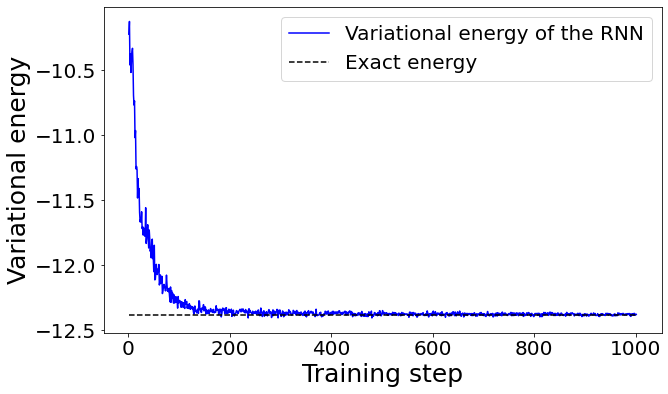

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.arange(1, len(RNNEnergy)+1), RNNEnergy, "b-", label="Variational energy of the RNN")
ax.plot(np.arange(1, len(RNNEnergy)+1), [E_exact]*len(RNNEnergy), "k--", label="Exact energy")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Variational energy', fontsize = 25)
plt.legend()

plt.show()

### **Energy variance**

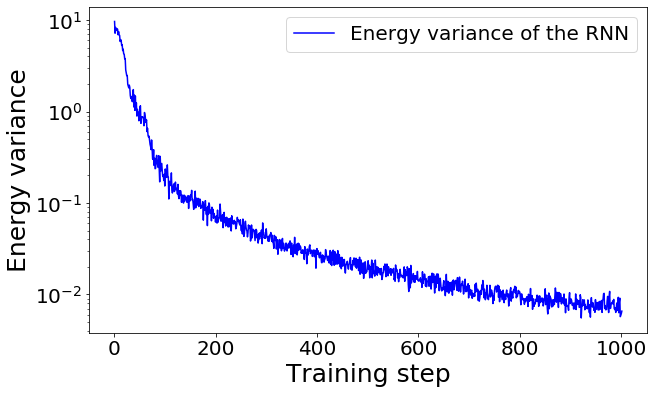

In [0]:
fig, ax = plt.subplots(figsize=(10,6))

ax.semilogy(np.arange(1, len(RNNEnergy)+1), varRNNEnergy, "b-", label="Energy variance of the RNN")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Energy variance', fontsize = 25)
plt.legend()

plt.show()

## **Explorations**

- If you want to explore large system sizes with the pRNN wavefunction, here are some ground states energy of 1DTFIM at the critical point (Bx = 1) given by DMRG and can be considered exact:


> N=20 : -25.1077971081

> N=30 : -37.8380982304

> N=40 : -50.5694337844

> N=50 : -63.3011891370

> N=60 : -76.0331561023

> N=70 : -88.7652446334

> N=80 : -101.4974094169

> N=90 : -114.2296251736

> N=100 : -126.9618766964

> N=1000 : -1272.8762945220

- You can also play with the hyperparameters (memory units, number of layers, number of samples, learning rate) to obtain better accuracies.

 